In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define paths
dataset_dir = 'cats'
train_dir = 'cats_split/train'
val_dir = 'cats_split/validation'
test_dir = 'cats_split/test'

In [3]:
#split data into test 0.8, validate 0.1, test 0.1
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split


# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class
classes = os.listdir(dataset_dir)
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Split data
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    
    # Split into training and remaining (test + validation)
    train_images, remaining_images = train_test_split(images, test_size=0.4, random_state=42)
    
    # Split remaining into validation and test
    val_images, test_images = train_test_split(remaining_images, test_size=0.5, random_state=42)
    
    # Move images to respective directories
    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
    
    for image in val_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(val_dir, class_name, image))
    
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))


In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

#Load data with ImageGenerator
# Set up data generators

batch_size = 2

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical'
)

test_generator =val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 42 images belonging to 5 classes.
Found 14 images belonging to 5 classes.
Found 17 images belonging to 5 classes.


In [14]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

Number of training samples: 42
Number of validation samples: 14
Number of test samples: 17


In [15]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [47]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = len(train_generator.class_indices)

# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define L2 regularization strength and dropout rate
l2_strength = 0.001 #(e.g., l2(0.001) or l2(0.005)
dropout_rate = 0.3 #(e.g., 0.3 or 0.7)

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_strength))(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False



In [48]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
print(f"Train steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation steps: {validation_generator.samples // validation_generator.batch_size}")


Train steps per epoch: 21
Validation steps: 7


In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

lr_scheduler = LearningRateScheduler(scheduler)

In [51]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=15 // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=5 // validation_generator.batch_size,
    epochs=100,
    class_weight=class_weights,
    callbacks = [reduce_lr]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - accuracy: 0.1841 - loss: 3.5039 - val_accuracy: 0.2500 - val_loss: 3.2173 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6644 - loss: 3.0099 - val_accuracy: 0.0000e+00 - val_loss: 2.8708 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4094 - loss: 3.8690 - val_accuracy: 0.2500 - val_loss: 3.3377 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.8693 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3091 - loss: 2.6113 - val_accuracy: 1.0000 - val_loss: 1.0974 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7205 - loss: 2.4708 - val_accuracy: 0.7500 - val_loss: 1.9052 - learning_rate: 5.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy

Epoch 44/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.7773 - learning_rate: 1.0000e-06
Epoch 45/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.8872 - loss: 1.2725 - val_accuracy: 0.7500 - val_loss: 1.6033 - learning_rate: 1.0000e-06
Epoch 46/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9592 - loss: 1.1092 - val_accuracy: 1.0000 - val_loss: 1.3300 - learning_rate: 1.0000e-06
Epoch 47/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9414 - loss: 1.2381 - val_accuracy: 0.7500 - val_loss: 1.4195 - learning_rate: 1.0000e-06
Epoch 48/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.2680 - learning_rate: 1.0000e-06
Epoch 49/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.9592 - loss: 1.2586 - val_accuracy: 0.7500 - val_loss: 1.5348 - learning_rate: 1.0000e-06
Epoch 50/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step

Epoch 87/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 1.3151 - val_accuracy: 0.7500 - val_loss: 1.7037 - learning_rate: 1.0000e-06
Epoch 88/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.7966 - learning_rate: 1.0000e-06
Epoch 89/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8351 - loss: 1.7004 - val_accuracy: 1.0000 - val_loss: 1.3430 - learning_rate: 1.0000e-06
Epoch 90/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9028 - loss: 1.1622 - val_accuracy: 0.7500 - val_loss: 1.7037 - learning_rate: 1.0000e-06
Epoch 91/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8143 - loss: 1.4088 - val_accuracy: 0.7500 - val_loss: 1.7150 - learning_rate: 1.0000e-06
Epoch 92/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.2657 - learning_rate: 1.0000e-06
Epoch 93/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step 

In [52]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7775 - loss: 1.5607
Test accuracy: 0.75, Test loss: 1.5522007942199707


In [53]:
# Save the entire model to a file
model.save('cat_model_final.h5')
model.save('cat_model_final.keras')

In [94]:
from tensorflow.keras.models import load_model
# load previous model for fine tune
model = load_model('cat_model_finetune1_layer15.h5')

In [95]:
# fine tuning

# Unfreeze some layers of the base model
for layer in base_model.layers[-15:]:
    layer.trainable = True
    
    
# Re-compile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


# Continue training with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=15 // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=5 // validation_generator.batch_size,
    epochs=200,
    class_weight=class_weights,
    callbacks = [reduce_lr]
)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accuracy: 0.9436 - loss: 0.6818 - val_accuracy: 0.7500 - val_loss: 0.9428 - learning_rate: 7.5000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8112 - loss: 0.9879 - val_accuracy: 1.0000 - val_loss: 0.4833 - learning_rate: 7.5000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.5899 - val_accuracy: 0.7500 - val_loss: 2.1389 - learning_rate: 7.5000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 4.6983 - learning_rate: 7.5000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8068 - loss: 0.8293 - val_accuracy: 1.0000 - val_loss: 0.4551 - learning_rate: 7.5000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6580 - loss: 3.5013 - val_accuracy: 0.7500 - val_loss: 2.2630 - learning_rate: 7.5000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.

Epoch 44/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4050 - learning_rate: 2.3438e-05
Epoch 45/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 1.0000 - loss: 0.4286 - val_accuracy: 1.0000 - val_loss: 0.5346 - learning_rate: 2.3438e-05
Epoch 46/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9821 - loss: 0.4998 - val_accuracy: 1.0000 - val_loss: 0.5186 - learning_rate: 2.3438e-05
Epoch 47/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.4056 - val_accuracy: 1.0000 - val_loss: 0.4052 - learning_rate: 2.3438e-05
Epoch 48/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4511 - learning_rate: 2.3438e-05
Epoch 49/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 1.0000 - loss: 0.4132 - val_accuracy: 1.0000 - val_loss: 0.4952 - learning_rate: 2.3438e-05
Epoch 50/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step

Epoch 87/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.4049 - val_accuracy: 1.0000 - val_loss: 0.4293 - learning_rate: 1.8311e-07
Epoch 88/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4044 - learning_rate: 1.8311e-07
Epoch 89/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9717 - loss: 0.4484 - val_accuracy: 1.0000 - val_loss: 0.4288 - learning_rate: 1.8311e-07
Epoch 90/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.4361 - val_accuracy: 0.5000 - val_loss: 1.1931 - learning_rate: 1.8311e-07
Epoch 91/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.4047 - val_accuracy: 1.0000 - val_loss: 0.4051 - learning_rate: 1.0000e-07
Epoch 92/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.5743 - learning_rate: 1.0000e-07
Epoch 93/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step 

Epoch 172/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5667 - learning_rate: 1.0000e-07
Epoch 173/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 1.0000 - loss: 0.4156 - val_accuracy: 1.0000 - val_loss: 0.5098 - learning_rate: 1.0000e-07
Epoch 174/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.4253 - val_accuracy: 1.0000 - val_loss: 0.4053 - learning_rate: 1.0000e-07
Epoch 175/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9821 - loss: 0.4776 - val_accuracy: 1.0000 - val_loss: 0.4046 - learning_rate: 1.0000e-07
Epoch 176/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.5663 - learning_rate: 1.0000e-07
Epoch 177/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 1.0000 - loss: 0.4059 - val_accuracy: 1.0000 - val_loss: 0.4051 - learning_rate: 1.0000e-07
Epoch 178/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160

In [96]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9267 - loss: 0.9110
Test accuracy: 0.875, Test loss: 1.2443432807922363


In [97]:
# Save the entire model to a file
model.save('cat_model_finetune2_layer15.h5')
model.save('cat_model_finetune2_layer15.keras')

# Optionally, save only the model weights if you don't need to save the entire architecture
#model.save_weights('shape_weight_74acc.weights.h5')

To be continue: fine tune on shape_model_finetune3_layer15.h, fine tune on learning rate to get a higher accuraccy....

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


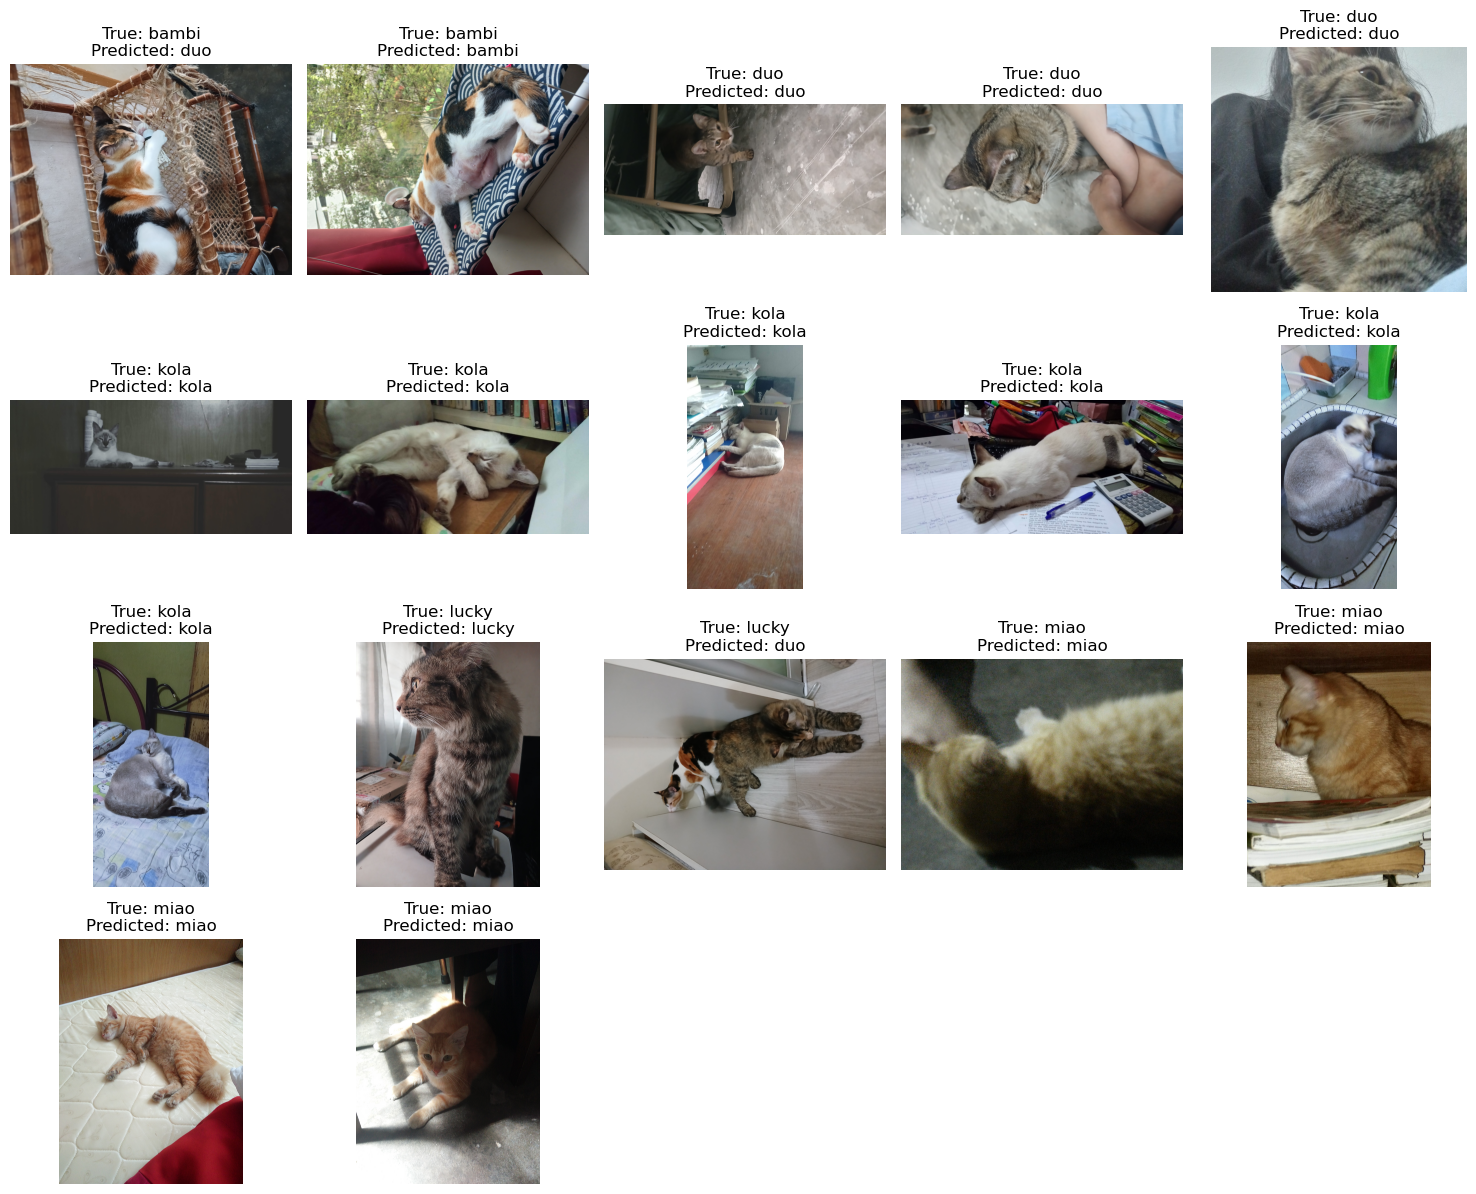

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your model
model = load_model('cat_model_finetune2_layer15.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to collect images and predictions
def collect_images_and_predictions(test_dir, target_size, class_names):
    images = []
    true_labels = []
    predicted_labels = []
    
    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                
                # Preprocess image
                img_array = preprocess_image(img_path, target_size)
                
                # Make predictions
                predictions = model.predict(img_array)
                predicted_index = np.argmax(predictions[0])
                predicted_label = class_names[predicted_index]  # Map index to class name
                
                images.append(img_path)
                true_labels.append(category)
                predicted_labels.append(predicted_label)
    
    return images, true_labels, predicted_labels

# Function to display images in a grid
def display_images_grid(images, true_labels, predicted_labels, num_per_row=5):
    num_images = len(images)
    num_rows = (num_images + num_per_row - 1) // num_per_row
    
    plt.figure(figsize=(15, num_rows * 3))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_per_row, i + 1)
        img = image.load_img(images[i])
        plt.imshow(img)
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Directory containing the test dataset
test_dir = 'cats_split/test'
target_size = (224, 224)  # Use the size that your model expects

class_names = ['bambi', 'duo', 'kola','lucky','miao'] 

# Collect images and predictions
images, true_labels, predicted_labels = collect_images_and_predictions(test_dir, target_size, class_names)

# Display images in a grid
display_images_grid(images, true_labels, predicted_labels)